###  Planet Analytics API Tutorial

<h1 style="margin-top:10px;">Planet Analytic Feeds Results</h1>

## Overview

1. [Introduction](#1.-Introduction) 

> Introduction to Analytic Feed Results types: Object Detection vs Segmentation

2. [Getting Results](#2.-Getting-Results) 

> Get Results for a Subscription from the API

3. [Working with Planet Analytics Results](#3.-Working-with-Planet-Analytics-Results) 

> Interpret and visualize Results with source satellite imagery

4. [Segmentation Results](#4.-Segmentation-Results)

> Visualizing Segmentation masks



## 1. Introduction

In the previous notebook, we explored the Planet Analytics Feeds API mechanics and core concepts of **Feeds** and **Subscriptions**. We worked through making requests to the API, understanding the response data, and showed how to create some basic visualizations with the data. It's encouraged to work through the first notebook before continuing.

In this notebook, we'll focus on Planet Analytic Feeds **Results**. Results represent the "detections" made in source Planet satellite imagery scenes for different types of objects visible on the ground. 

### Analytic Feed Results

**Results** on the Planet Analytics API represent the output or "detections" of our machine learning models. Results are created for each Subscription, and each Subscription is derived from a Feed:

*Feed → Subscription → Results* 

> When new Planet imagery is published that intersects a Subscription's AOI and TOI, Planet’s computer vision models process the imagery and the output is added to a "collection" (WFS 3) of Results associated with a Subscription.


#### Feed / Result Types

As we've seen, several types of **Feeds** exist, and Results for Feed Subscriptions can be categorized as one of three types: `Object Detection`, `Segmentation`, and `Change Detection`. This notebook covers the `Object Detection` and `Segmentation` feed types, while the next notebook covers `Change Detection` feeds.


#### Types of Feeds + Result Output Format

| Feed Type | Results Type | Results Format | Results Access |
| --- | --- | --- | --- |
| Vessel Detection | Object Detection | Detection Features (Polygons) | WFS 3 (Detection Features) |
| Building Detection | Segmentation (Classification) | Raster Mask / Basemaps | WFS 3 (Quads) / XYZ Tiles |
| Road Detection | Segmentation (Classification) | Raster Mask / Basemaps | WFS 3 (Quads) / XYZ Tiles |
| Building Construction Detection | Change Detection | Raster Mask / Basemaps | WFS 3 (Quads) / XYZ Tiles |
| Road Construction Detection | Change Detection | Raster Mask / Basemaps | WFS 3 (Quads) / XYZ Tiles |


Outputs for **all** Results (of any Feed type) are delivered via `WFS 3` compliant endpoint on the API. The "shape" of the data representing Results for each Subscription are specific to the Subscription's Feed. 

*Object Detection** type Feeds Results output are returned as `GeoJSON Features` with polygonal geometries representing bounding boxes around detections made by the machine learning model. For example, a box around a ship. 

*Segmentation* type Feeds Results output are `GeoJSON Features` that describe "Quads" (individual raster files) that make up a larger segmentation / classification "mask". The Planet Analytics API lists links to these segmentation quads on the Planet Mosaics API where the raster files are stored, but also links to XYZ basemap tiles that can be used to view the raster data. 


`Change Detection` feeds are discussed in the following notebook.

### WFS 3


<img src="http://www.opengeospatial.org/pub/www/files/OGC_Logo_2D_Blue_x_0_0.png" align="right" style="margin-left: 20px" width="100"></img>

The Planet Analytics API's **Results** (`collections` and `items`) endpoints follow the [Open Geospatial Consortium's](http://www.opengeospatial.org) (OGC) [Web Feature Service 3.0](https://github.com/opengeospatial/WFS_FES) (WFS) specification.


> A Web Feature Service (WFS) is a standard API that represents collections of geospatial data.


## 2. Getting Results

Let's get started by accessing one of our Subscriptions. We'll see how we can get it's associated **Results** and we'll explore and visualize the data!

First we'll setup our API `base url` and `authentication` so we can make our `request`, just like in the previous tutorial.

In [1]:
pip install shapely==1.8.5

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install daal==2021.4.0

  Using cached daal-2021.4.0-py2.py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.whl (189.9 MB)
  Obtaining dependency information for tbb==2021.* from https://files.pythonhosted.org/packages/3c/45/23849b7d10766d4a4df7b2fa1825c92e349bf73ba53458ff98765823fbe4/tbb-2021.10.0-py2.py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.whl.metadata
  Using cached tbb-2021.10.0-py2.py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.whl.metadata (989 bytes)
Using cached tbb-2021.10.0-py2.py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.whl (640 kB)
  Attempting uninstall: tbb
    Found existing installation: TBB 0.2
ERROR: Cannot uninstall 'TBB'. It is a distutils installed project and thus we cannot accurately determine which files belong to it which would lead to only a partial uninstall.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install numpy==1.21.0

Note: you may need to restart the kernel to use updated packages.


### Import Packages

In [4]:
from datetime import datetime
import json
import os
from planet import Auth
from planet import Session, DataClient, OrdersClient, data_filter
import pprint
import requests
import geoviews as gv
import geopandas as gpd
import pandas as pd
import pyproj
import pandas as pd

import geopandas as gpd
from shapely.geometry import shape
from fiona.crs import from_epsg
from ipyleaflet import Map, GeoData, basemaps, LayersControl, TileLayer
from IPython.display import Image
from IPython.core.display import HTML
import holoviews as hv
from shapely.geometry import shape
from pandas import json_normalize
from datetime import timedelta

In [5]:
# Configure Auth and Base URL

# Planet Analytics API Base URL
PAA_BASE_URL = "https://api.planet.com/analytics/"

# API Key Config
if os.environ.get('PL_API_KEY', 'PLAKc5a71489528f4bfe8fa087bfd60befc7'):
    API_KEY = os.environ.get('PL_API_KEY', 'PLAKc5a71489528f4bfe8fa087bfd60befc7')
else:
    API_KEY = 'PLAKc5a71489528f4bfe8fa087bfd60befc7'

# Setup Auth
BASIC_AUTH = (API_KEY, '')

We'll make a couple helper functions for "pretty printing" our responses:

In [6]:
# Pretty Print Helper
pp = pprint.PrettyPrinter(indent=4)

# JSON Pretty Print Helper
def jpp(data):
    print(json.dumps(data, indent=4))

Now let's use the `Requests` library to get the Subscription. We'll get the Subscription using its `id`, which is a [Universally Unique Identifier](https://en.wikipedia.org/wiki/Universally_unique_identifier) (UUID) string. 

*Remember, we can see a list of available Subscriptions (and their `ids` by making a request to the `/subscriptions` endpoint. See the previous tutorial for more details.*

_**Note:** If you do not have access to the Analytics Feeds API or the specific example subscription IDs used in the example code below, you may not be able to run through these examples. Contact [Sales](https://go.planet.com/getintouch) to learn more._

In [7]:
# Request a Subscription

# Define the Subscription UUID, which in this case is for Ship Detections
subscription_id = "9db92275-1d89-4d3b-a0b6-68abd2e94142"

# Construct the URL for the Subscription
subscription_url = PAA_BASE_URL + 'subscriptions/' + subscription_id

print("Request URL: {}".format(subscription_url))

# Make the GET request for Subscriptions list 
subscription = requests.get(subscription_url, auth=BASIC_AUTH).json()

Request URL: https://api.planet.com/analytics/subscriptions/9db92275-1d89-4d3b-a0b6-68abd2e94142


Let's take a look at the Subscription we just requested:

In [8]:
# Print some data
print("{} \n{}\nSubscription Id: {}\n".format(subscription['title'], subscription['description'], subscription['id']))

# Print the subscription object
print(json.dumps(subscription, sort_keys=True, indent=4))

Port of Oakland, USA 
Daily Vessel Detection
Subscription Id: 9db92275-1d89-4d3b-a0b6-68abd2e94142

{
    "created": "2019-04-11T18:03:18.890Z",
    "description": "Daily Vessel Detection",
    "endTime": "2019-07-01T00:00:00.000Z",
    "feedID": "1b4c9ee2-699b-4621-bb4f-934eda8090b5",
    "geometry": {
        "coordinates": [
            [
                [
                    -122.355422973633,
                    37.7517152984565
                ],
                [
                    -122.243843078613,
                    37.7517152984565
                ],
                [
                    -122.243843078613,
                    37.838530034214
                ],
                [
                    -122.355422973633,
                    37.838530034214
                ],
                [
                    -122.355422973633,
                    37.7517152984565
                ]
            ]
        ],
        "type": "Polygon"
    },
    "id": "9db92275-1d89-4d3b-a0b6-6

The above output should look familiar from the previous tutorial. We see the title, AOI, TOI, and other metadata about the Subscription.

Now we can move on to getting the **Results** for this Subscription:

#### Subscription Results Collection

We can use the Subscription `id` property to get the **Results** `collection` and `items` for this Subscription.

We can get the `collection` by making a request to the `/collections` endpoint with the `id` from our Subscription:

In [9]:
# Construct the URL for the subscription's Results collection
subscription_results_url = PAA_BASE_URL + 'collections/' + subscription['id']

print("Request URL: {}".format(subscription_results_url))

# Get subscription results collection
subscription_results = requests.get(subscription_results_url, auth=BASIC_AUTH).json()

# Pretty Print response JSON
print(json.dumps(subscription_results, sort_keys=True, indent=4))

Request URL: https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142
{
    "created": "2019-04-11T18:03:18.890Z",
    "description": "Daily Vessel Detection",
    "extent": {
        "spatial": {
            "bbox": [
                [
                    -122.355422973633,
                    37.7517152984565,
                    -122.243843078613,
                    37.838530034214
                ]
            ]
        },
        "temporal": {
            "interval": [
                [
                    "2019-01-01T00:00:00.000Z",
                    "2019-07-01T00:00:00.000Z"
                ]
            ]
        }
    },
    "id": "9db92275-1d89-4d3b-a0b6-68abd2e94142",
    "links": [
        {
            "href": "https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142",
            "rel": "self",
            "type": "application/json"
        },
        {
            "href": "https://api.planet.com/analytics/collections/

#### Subscription Results Items

Now let's get the actual **Results** `items` from the `collection`. Our request endpoint should be constructed like this: `/collections/{ID}/items`

But we don't need to construct the **Results** `items` URL manually, it's one of the `links` that's provided in our Subscription response. Let's use the link from our Subscription response from the previous cell:

In [10]:
# Construct the URL
subscription_items_url = list(filter(lambda link: link['rel'] == 'results', subscription['links']))[0]['href']

print("Subscription Items URL:\n{}\n".format(subscription_items_url))

Subscription Items URL:
https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142/items



We'll use the `url` to make our request:

In [11]:
# Request subscription Items

# Get request Subscription features (collection items)
subscription_items = requests.get(subscription_items_url, auth=BASIC_AUTH).json()

# Pretty Print response JSON
print("Subscription Results Collection Items: (GeoJSON FeatureCollection):\n {}".format(json.dumps(subscription_items, sort_keys=True, indent=4)))


Subscription Results Collection Items: (GeoJSON FeatureCollection):
 {
    "features": [
        {
            "created": "2022-10-27T22:53:29.202Z",
            "geometry": {
                "coordinates": [
                    [
                        [
                            -122.321902511231,
                            37.7985556136176
                        ],
                        [
                            -122.321911880908,
                            37.797530647137
                        ],
                        [
                            -122.324780667438,
                            37.797547124339
                        ],
                        [
                            -122.324771337394,
                            37.7985720914244
                        ],
                        [
                            -122.321902511231,
                            37.7985556136176
                        ]
                    ]
                ],
      

Nice! Now we've got our first set of **Results** data. The **Results** for a Subscription come to us as a `GeoJSON` `FeatureCollection`.

Each `item` is a `GeoJSON Feature` listed in the the `features` property of the `FeatureCollection`. Let's check how many `items` (Features) we have so far:

In [12]:
# Print the number of Features in the subscription's collection:
print("\nNumber of Items (Features): {} \n".format(len(subscription_items['features'])))


Number of Items (Features): 250 



The request we made to get these `items` is actually a **paged** list of results. 

In our `GeoJSON` Feature Collection, we see there is a `links` property, which conforms to the [WFS 3.0 Spec](https://github.com/opengeospatial/WFS_FES/blob/master/core/openapi/schemas/featureCollectionGeoJSON.yaml#L14) in accordance with the [OpenAPI spec for Links](https://swagger.io/docs/specification/links/). 

Let's look at the `links` property to see how we can get all the **Results** `items` for our Subscription:

In [13]:
# Pretty Print the links
pp.pprint(subscription_items['links'])

[   {   'href': 'https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142/items',
        'rel': 'self',
        'type': 'application/geo+json'},
    {   'href': 'https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142',
        'rel': 'collection',
        'type': 'application/json'},
    {   'href': 'https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142/items?before=06c7f0f0-7d24-4ac2-880d-b2bb3ec70693',
        'rel': 'next',
        'type': 'application/json'}]


The `"rel" : "next"` property's `href` should contain a URL with a [`query string`](https://en.wikipedia.org/wiki/Query_string) `?before={ITEM_ID}` where the `ITEM_ID` is the UUID identifier.

We can use the `link` with the `rel` value "`next`" to get the next page of data, and follow each subsequent `next` link to request all the pages of data and get the entire `FeatureCollection` for this subscription's items. 

Let's write a helper function to do this:

In [14]:
# Helper to get the "next" link
def get_next_link(links):
    for link in links:
        if link['rel'] == 'next':
            return link['href']

We can use our helper function to get the first "next" link:

In [15]:
# Get the first "next" link
next_link = get_next_link(subscription_items['links'])
page_number = 2   

print(next_link)

https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142/items?before=06c7f0f0-7d24-4ac2-880d-b2bb3ec70693


Now let's iterate through our data and follow each "next" link to get all the data associated with our Subscription's Results Collection.

In [16]:
# Loop to get all pages of features
while next_link:
    print("Getting page number {} at {}".format(page_number, next_link))
    
    # Use "next" link to request next page
    next_collection = requests.get(next_link, auth=BASIC_AUTH).json()
        
    print("Found {} additional Features \n".format(len(next_collection['features'])))
    
    # Get the next "next" link
    next_link = get_next_link(next_collection["links"])

    # Add features from new page to our original list of features
    subscription_items['features'].extend(next_collection['features'])
    
    # increment the page number
    page_number += 1
    
print("Total Subscription Items: {}".format(len(subscription_items['features'])))  

Getting page number 2 at https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142/items?before=06c7f0f0-7d24-4ac2-880d-b2bb3ec70693
Found 250 additional Features 

Getting page number 3 at https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142/items?before=0307bbd3-4540-48ee-87d2-6908af802d6d
Found 250 additional Features 

Getting page number 4 at https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142/items?before=f6988920-7c9a-4000-b4b7-71095f48d9f2
Found 250 additional Features 

Getting page number 5 at https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142/items?before=58ff9285-eef0-4fcf-a604-88bd883b654f
Found 250 additional Features 

Getting page number 6 at https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142/items?before=77297a22-fc7b-41aa-8d50-ef5c5b249895
Found 250 additional Features 

Getting page number 7 at https://api.planet.com/analyti

We can also increase the number of results returned on each page (default 250, max 10000) 
by changing the limit query parameter on the number of results that are returned:

`requests.get(subscription_items_url, params={"limit": 500} )`

Here's our final **Results** `FeatureCollection`:

In [17]:
# Now we have our complete GeoJSON Feature Collection
subscription_items

{'features': [{'created': '2022-10-27T22:53:29.202Z',
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-122.321902511231, 37.7985556136176],
      [-122.321911880908, 37.797530647137],
      [-122.324780667438, 37.797547124339],
      [-122.324771337394, 37.7985720914244],
      [-122.321902511231, 37.7985556136176]]]},
   'id': '3f758abf-a88e-452a-93bf-b989df5e2fb0',
   'links': [{'href': 'https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142/items/3f758abf-a88e-452a-93bf-b989df5e2fb0',
     'rel': 'self',
     'type': 'application/geo+json'},
    {'href': 'https://api.planet.com/analytics/collections/9db92275-1d89-4d3b-a0b6-68abd2e94142/items/3f758abf-a88e-452a-93bf-b989df5e2fb0/resources/source-image-info',
     'rel': 'source-image-info',
     'type': 'application/json'},
    {'href': 'https://tiles.planet.com/data/v1/PSScene/20190317_184156_63_105d/{z}/{x}/{y}.png?api_key=PLAKc5a71489528f4bfe8fa087bfd60befc7',
     'rel': 'source-tiles',
     't

## 3. Working with Planet Analytics Results

Now that we've got our **Results** let's use use GeoPandas to explore our data like we did in the previous tutorial.

In [18]:
!pip list

Package                       Version
----------------------------- --------------------
affine                        2.4.0
aiohttp                       3.8.1
aiosignal                     1.2.0
alabaster                     0.7.12
anaconda-client               1.9.0
anaconda-navigator            2.1.4
anaconda-project              0.10.2
anyio                         3.5.0
appdirs                       1.4.4
applaunchservices             0.2.1
appnope                       0.1.2
appscript                     1.1.2
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.6.6
astropy                       5.0.4
asttokens                     2.0.5
async-timeout                 4.0.1
atomicwrites                  1.4.0
attrs                         23.1.0
Automat                       20.2.0
autopep8                      2.0.2
Babel                         2.9.1
backcall                      0.2.0
backp

requests-file                 1.5.1
requests-futures              0.9.9
rfc3986                       1.5.0
rio-cogeo                     4.0.1
rope                          0.22.0
rsa                           4.7.2
Rtree                         0.9.7
ruamel.yaml                   0.17.32
ruamel.yaml.clib              0.2.7
ruamel-yaml-conda             0.15.100
s3transfer                    0.5.0
scikit-image                  0.19.2
scikit-learn                  1.0.2
scikit-learn-intelex          2021.20220215.132722
scipy                         1.7.3
Scrapy                        2.6.1
seaborn                       0.11.2
Send2Trash                    1.8.0
service-identity              18.1.0
setuptools                    68.0.0
Shapely                       1.8.5
sip                           4.19.13
six                           1.16.0
smart-open                    5.1.0
sniffio                       1.2.0
snowballstemmer               2.2.0
snuggs                        1.4.7


In [19]:
pip install pyproj==3.3.1

Note: you may need to restart the kernel to use updated packages.


In [20]:
pip install geopandas==0.11.1

Note: you may need to restart the kernel to use updated packages.


In [21]:
print(pyproj.__version__)

3.3.1


In [22]:
# Make a GeoPandas data frame from our collection items
# Since we're importing a GeoJSON file, we can use the `from_features` method
gdf = gpd.GeoDataFrame.from_features(subscription_items['features'])

# Show the first five results from our GeoDataFrame
gdf.head()

,geometry,_g4_task_instance_id,_object_class_idx,intersects,model_id,model_version,object_area_m2,object_diagonal_m,object_length_m,object_width_m,...,score,source_asset_type,source_cloud_cover,source_item,source_item_id,source_item_type,xmax_px,xmin_px,ymax_px,ymin_px
0,"POLYGON ((-122.32190 37.79856, -122.32191 37.7...",taski_01GGDSYKARNMSENEHY2B4W04H2,1,False,01DPSEHT77T7HHJZHAHCKFDPEK,2019-10-16T00:58:07Z,28725.010137,277.002673,252.580333,113.726234,...,0.999963,ortho_visual,0.0,20190317_184156_63_105d,20190317_184156_63_105d,PSScene,3769,3685,2806,2768
1,"POLYGON ((-122.31775 37.79765, -122.31776 37.7...",taski_01GGDSYKARNMSENEHY2B4W04H2,1,False,01DPSEHT77T7HHJZHAHCKFDPEK,2019-10-16T00:58:07Z,37839.690285,315.165080,286.062241,132.277822,...,0.999938,ortho_visual,0.0,20190317_184156_63_105d,20190317_184156_63_105d,PSScene,3892,3796,2845,2801
2,"POLYGON ((-122.33770 37.80879, -122.33772 37.8...",taski_01GGDSYKARNMSENEHY2B4W04H2,1,False,01DPSEHT77T7HHJZHAHCKFDPEK,2019-10-16T00:58:07Z,67785.308549,376.562368,302.790302,223.868823,...,0.999865,ortho_visual,0.0,20190317_184156_63_105d,20190317_184156_63_105d,PSScene,3303,3202,2467,2393
3,"POLYGON ((-122.30954 37.81954, -122.30954 37.8...",taski_01GGDSYKARNMSENEHY2B4W04H2,1,False,01DPSEHT77T7HHJZHAHCKFDPEK,2019-10-16T00:58:07Z,20990.256823,294.866162,285.557127,73.506331,...,0.999760,ortho_visual,0.0,20190317_184156_63_105d,20190317_184156_63_105d,PSScene,4127,4031,2014,1989
4,"POLYGON ((-122.33662 37.76174, -122.33664 37.7...",taski_01GGDSYKARNMSENEHY2B4W04H2,1,False,01DPSEHT77T7HHJZHAHCKFDPEK,2019-10-16T00:58:07Z,17826.436962,208.570526,184.968781,96.375382,...,0.999461,ortho_visual,0.0,20190317_184156_63_105d,20190317_184156_63_105d,PSScene,3347,3315,4194,4133


When we created the DataFrame with the `.from_features()` method, GeoPandas automatically converted our `GeoJSON` geometries to `Shapely` shapes.

### Result Item Properties

Let's take a look at the rest of the columns available to us:

In [23]:
# List the item properties (columns)
for column in gdf.columns.values:
    print(column)

geometry
_g4_task_instance_id
_object_class_idx
intersects
model_id
model_version
object_area_m2
object_diagonal_m
object_length_m
object_width_m
observed
score
source_asset_type
source_cloud_cover
source_item
source_item_id
source_item_type
xmax_px
xmin_px
ymax_px
ymin_px


Most of these properties should be self-explanatory, and different Feed types may include different properties.

##### Source Properties
The `source_` properties all relate to the source satellite imagery that the detections were made against. We'll see how we can use these later on.

##### Detection Object Properties
The `object_` properties describe some meta-data about each detection, like length and diagonal. 

Also relevant are `score` (the score assigned by the machine learning model), `geometry` (the "footprint" of the detection), and `observed`.

Let's convert our `observed` column data to a `datetime`. The `observed` column represents the date that a detection was made, based on when the source satellite image was taken.

In [24]:
# Convert observed column into a datetime datatype
gdf["observed"] = pd.to_datetime(gdf["observed"])

Let's visualize our **Results**. For starters, we can create a simple plot using GeoPandas built in `plot` method. Later on we'll make some more interesting interactive visualizations.

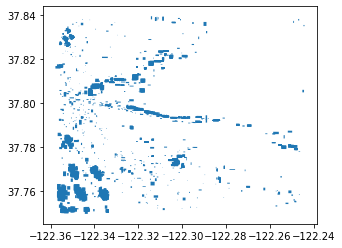

In [25]:
# Simple GeoPandas Plot of features
gdf.plot();

### Inspecting a single detection
We can use our GeoPandas GeoDataFrame to look at the first detection item. 

In [26]:
# Select the first detection by index
first_detection = gdf.iloc[[0]]
first_detection

,geometry,_g4_task_instance_id,_object_class_idx,intersects,model_id,model_version,object_area_m2,object_diagonal_m,object_length_m,object_width_m,...,score,source_asset_type,source_cloud_cover,source_item,source_item_id,source_item_type,xmax_px,xmin_px,ymax_px,ymin_px
0,"POLYGON ((-122.32190 37.79856, -122.32191 37.7...",taski_01GGDSYKARNMSENEHY2B4W04H2,1,False,01DPSEHT77T7HHJZHAHCKFDPEK,2019-10-16T00:58:07Z,28725.010137,277.002673,252.580333,113.726234,...,0.999963,ortho_visual,0.0,20190317_184156_63_105d,20190317_184156_63_105d,PSScene,3769,3685,2806,2768


Lets look at the first detection's geometry visually. When we created our GeoDataFrame from our collection items data, the features were automatically converted to Shapely Geometries:

0    POLYGON ((-122.32190 37.79856, -122.32191 37.7...
Name: geometry, dtype: geometry


<AxesSubplot:>

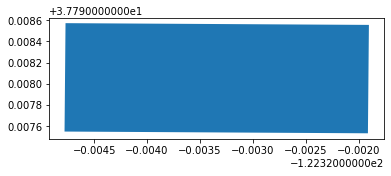

In [27]:
# Use shapely to show the first geometry
print(first_detection['geometry'])
first_detection.plot()

#### Interactive Visualizations with iPyLeaflet

Let's use **[ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/#)** to create an interactive web map with the subscription geometry so we can see a bit more context around the geometry. 

Leaflet is one of the most popular open-source JavaScript libraries for interactive maps. It’s widely used by GIS applications like OpenStreetMap, Mapbox, and CartoDB.

The ipyleaflet Python package makes it easy to integrate and control Leaflet maps in Python. It is released as part of the [PyViz](http://pyviz.org/) suite.

In [28]:


# Let's look at our multipolygon centroid in (Lat, Long)
print(first_detection['geometry'].centroid)

# We need to input the center of our map in reverse order (Long, Lat) 
# because we are working with a geodataframe (Shapely object)
# Make sure the coordinates below match the ones printed using the line above, in reverse order.

m = Map(center=(37.79709, -122.31941), zoom = 15, basemap= basemaps.Esri.WorldTopoMap)

# The "observed" datetime column is giving us trouble when visualizing, so let's take it out just for this map
first_detection_viz = first_detection.drop(['observed'], axis=1)

geo_data = GeoData(geo_dataframe = first_detection_viz, columns=['geometry'], name = 'Polygon')



m.add_layer(geo_data)
m.add_control(LayersControl())

m

0    POINT (-122.32334 37.79805)
dtype: geometry


Map(center=[37.79709, -122.31941], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

Nice!

If we zoom out a bit, we can start to get some more context by seeing where the detection occurred on the map.

**In the next section, we'll take a look at combining Planet Analytics Data with Planet Imagery**

### Analytics Detections and  Source Imagery

The metadata associated with a single detection contains some interesting information, but of course we're here because we want to see the detection with our own eyes too! 

We can easily access the satellite imagery data associated with each detection via several of Planet's [Data API](https://developers.planet.com/docs/api/) and [Tile services](https://developers.planet.com/docs/basemaps/tile-services/), and we'll be able to view `metadata`, and `imagery previews` if we like, as well as download the imagery `assets`. 

In order to find the image, we'll need the `scene id` and [`item_type`](https://developers.planet.com/docs/api/items-assets/) (sensor type) for the satellite image used to observe the detection.

In our analytics detections data, sensor type is stored as the `source_item_type` property, and scene id is stored as the `source_item_id`. 

**Let's get this information for a single detection from our subscription data:**

In [29]:
# Get the sensor type
item_type = first_detection['source_item_type'][0]

# Get the item id
scene_id = first_detection['source_item_id'][0]

print("Item Type: {} \nScene Id: {}".format(item_type, scene_id))

Item Type: PSScene 
Scene Id: 20190317_184156_63_105d


### Getting observation source imagery data

Using just these two peices of information, we can access everything we need to know about the satellite imagery used in the observation by getting it from Planet's Data API! 

We'll use the [Planet Python Client](https://planetlabs.github.io/planet-client-python/) in this example, but you can also make a request to the API directly with your preferred approach by constructing a URL that includes the `item_id` and `item_type`:

`https://api.planet.com/data/v1/item-types/{ITEM TYPE}/items/{ITEM ID}`

For more in depth guides on working with the Planet Data API, visit our [Planet School](https://developers.planet.com/planetschool/) section on the Planet [Developer Resource Center](https://developers.planet.com) website.

We can get information on our source satellite imagery scene by using the `get_item` method from the Planet Python Client:

In [30]:
id_filter = data_filter.string_in_filter('id', [scene_id])

async with Session() as sess:
    cl = DataClient(sess)
    item_list = cl.search(search_filter=id_filter, item_types=[item_type])
    items = [i async for i in item_list]

In [31]:
# Prett-print our scene info
item = items[0]
jpp(item)

{
    "_links": {
        "_self": "https://api.planet.com/data/v1/item-types/PSScene/items/20190317_184156_63_105d",
        "assets": "https://api.planet.com/data/v1/item-types/PSScene/items/20190317_184156_63_105d/assets/",
        "thumbnail": "https://tiles.planet.com/data/v1/item-types/PSScene/items/20190317_184156_63_105d/thumb"
    },
    "_permissions": [
        "assets.basic_analytic_4b:download",
        "assets.basic_analytic_4b_rpc:download",
        "assets.basic_analytic_4b_xml:download",
        "assets.basic_udm2:download",
        "assets.ortho_analytic_4b:download",
        "assets.ortho_analytic_4b_sr:download",
        "assets.ortho_analytic_4b_xml:download",
        "assets.ortho_udm2:download",
        "assets.ortho_visual:download"
    ],
    "assets": [
        "basic_analytic_4b",
        "basic_analytic_4b_rpc",
        "basic_analytic_4b_xml",
        "basic_udm2",
        "ortho_analytic_4b",
        "ortho_analytic_4b_sr",
        "ortho_analytic_4b_xml",

The result should be a `GeoJSON Feature` with the following noteable fields: 

* The scene metadata in `properties`
* The scene footprint in `geometry`
* Links to the scene imagery assets and previews in `_links` 

#### Source Imagery Previews and Visualizations

Let's actually view the scene viually by using the [`thumbnail`](https://developers.planet.com/docs/api/item-previews) link to preview our scene imagery with IPython:

In [32]:


# Get the thumbnail URL
# Append our api key to authenticate
thumb_url = item['_links']['thumbnail'] + '?api_key=' + API_KEY

# Render the preview image with IPython.display
Image(url=thumb_url)

There's a nice preview of our image, so we can take a peek without having to download the entire asset!

But we won't need to get all the scene meta data available on the Planet Data API just to see the preview. We only really need the `item_type` and `scene_id` to construct URLs for the scene image preview thumbnail, as well as (`xyz`) [tiles](https://developers.planet.com/docs/basemaps/tile-services/) we can use in a web map.

The URLs to these imagery previews look like:

* Thumbnails: `https://tiles.planet.com/data/v1/item-types/{ITEM TYPE}/items/{ITEM ID}/thumb`
* XYZ Tiles: `https://tiles{0-3}.planet.com/data/v1/{item_type}/{item_id}/{z}/{x}/{y}.png`

The backend webmap client will use this template XYZ tiles URL in our visualizations below.

Let's write a helper function that will let us grab the source imagery that our detections were observed in:

In [33]:
# Get source imagery helper utility
# Takes type xyz or thumb
def get_source_imagery_url(name, item_id, item_type, preview_type="xyz"):
    
    # Determine parts of URL
    prefix = "https://tiles1.planet.com/data/v1/" if preview_type == "xyz" else "https://tiles.planet.com/data/v1/"
    
    one = item_type + "/" if preview_type == "xyz" else "item-types/"
    two = item_id if preview_type == "xyz" else item_type
    three = "/8/2/2.png" if preview_type == "xyz" else "/items/"
    four = "" if preview_type == "xyz" else item_id
    five = "" if preview_type == "xyz" else "/thumb"
    
    # Construct the URL
    source_imagery_url = prefix + one + two +\
                         three + four + five + "?api_key=" + API_KEY
    
    return source_imagery_url

Using our helper function, we can construct the preview URLs:

In [34]:
# Get the scene thumbnail URL
thumb_url = get_source_imagery_url("thumburl", scene_id, 'PSScene', preview_type = 'thumb')

# Get the scene tiles URL
tiles_url = get_source_imagery_url("tilesurl", scene_id,  'PSScene', preview_type = 'xyz')

# Print the thumbnail link
print("Thumbnail URL:")
HTML('<a href="{}" target="_blank">Thumbnail URL</a>'.format(tiles_url))

Thumbnail URL:


#### View a single detection with it's source Planet Imagery

Let's put our preview images to work by overlaying a detection on a web map with the observation imagery xyz tiles:

In [35]:
# Let's look at our multipolygon centroid in (Lat, Long)
print(first_detection['geometry'].centroid)

# We need to input the center of our map in reverse order (Long, Lat) 
# because we are working with a geodataframe (Shapely object)
# Make sure the coordinates below match the ones printed using the line above, in reverse order.


geo_data = GeoData(geo_dataframe = first_detection_viz, columns=['geometry'], name = 'Polygon')

tilelayer = TileLayer(url=tiles_url, opacity=1, name = 'TileLayer')
m = Map(default_tiles=tilelayer, center=(37.79709, -122.31941), zoom=15, basemap= basemaps.Esri.WorldTopoMap)


m.add_layer(geo_data)
m.add_layer(tilelayer)
m.add_control(LayersControl())

m

0    POINT (-122.32334 37.79805)
dtype: geometry


Map(center=[37.79709, -122.31941], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title',…

In [36]:
basemap = gv.tile_sources.CartoLight

In [37]:
# Plot the detection geometry
single_detection = gv.Shape(first_detection['geometry'], label="Detection in {} - {}".format(item_type, scene_id)).opts(
    fill_alpha=0, 
    line_color="red", 
    width=600, height=500, padding=3,
)

# Plot with web map tiles
single_detection * basemap * gv.WMTS(data=tiles_url)

:Overlay
   .Shape.Detection_in_PSScene_hyphen_minus_20190317_184156_63_105d :Shape   [Longitude,Latitude]
   .WMTS.I                                                          :WMTS   [Longitude,Latitude]
   .WMTS.II                                                         :WMTS   [Longitude,Latitude]

We now have an interactive map with our detection geometry and Planet source imagery. Pan around the map to see more of the scene!

### Visualize All Detections 

#### Detection Thumbnails

Let's use this same method to create thumbnails to view more detections with their source imagery. Let's create a function to render these visualizations:

In [38]:
# Helper function to render a thumbnail for an item
# Takes an index (row) from DataFrame
def render_item_thumb(index):
    # Get the item row from DataFrame
    item = gdf.iloc[index]
    
    # Construct tile URL
    tile_url = get_source_imagery_url(item['source_item_id'], item['source_item_type'], 'xyz')   
    
    # Create detection plot
    detection = gv.Shape(item['geometry']).opts(
        fill_alpha=0, 
        line_color="red", 
        width=200, height=200,
        default_tools=[],
        xaxis=None,
        yaxis=None
    ) 
    
    return (detection * basemap * gv.WMTS(data=tile_url))

Now let's use our helper function to render a Holoviews `Layout`. We'll render the first twenty detections:

In [39]:
# Iterate through the first 20 thumbs
thumbs_list = [render_item_thumb(i) for i in list(gdf.index[0:20])]

# Create a Layout visualization
layout = hv.Layout(thumbs_list).opts(shared_axes=False).cols(4)
layout

:Layout
   .Overlay.I     :Overlay
      .Shape.I :Shape   [Longitude,Latitude]
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .WMTS.II :WMTS   [Longitude,Latitude]
   .Overlay.II    :Overlay
      .Shape.I :Shape   [Longitude,Latitude]
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .WMTS.II :WMTS   [Longitude,Latitude]
   .Overlay.III   :Overlay
      .Shape.I :Shape   [Longitude,Latitude]
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .WMTS.II :WMTS   [Longitude,Latitude]
   .Overlay.IV    :Overlay
      .Shape.I :Shape   [Longitude,Latitude]
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .WMTS.II :WMTS   [Longitude,Latitude]
   .Overlay.V     :Overlay
      .Shape.I :Shape   [Longitude,Latitude]
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .WMTS.II :WMTS   [Longitude,Latitude]
   .Overlay.VI    :Overlay
      .Shape.I :Shape   [Longitude,Latitude]
      .WMTS.I  :WMTS   [Longitude,Latitude]
      .WMTS.II :WMTS   [Longitude,Latitude]
   .Overlay.VII   :Overlay
     

#### Interactive Detections Plot

Using GeoViews, we can also plot all our detections on a single interactive map and color our detections based on their `score` values. 

We can include a histogram using the `.hist` method on our GeoViews `Polygons` element to show a break down of overall scores.

In [40]:
# Plot all features on a map

# Pick the properties (dimensions) we want to include
items_dimensions = ['score', 'object_diagonal_m', 'observed']

# Plot the features with GeoViews
all_features_plot = gv.Polygons(gdf, vdims=items_dimensions).opts(
    colorbar_position="bottom", colorbar_opts={"title": "score"},
    cmap="RdYlBu_r", 
    width=600, height=500,
    colorbar=True,
    title="All Detections for {}".format(subscription['title']))

# Plot the features map with a histogram and basemap 
all_features_plot.hist() * basemap

:AdjointLayout
   :Overlay
      .Polygons.I :Polygons   [Longitude,Latitude]   (score,object_diagonal_m,observed)
      .WMTS.I     :WMTS   [Longitude,Latitude]
   :Histogram   [score]   (score_count)

#### Visualize by Time Dimension

We can also make a visualization that let's us interactively view detections for certain days using a HoloMap. First let's organize our data by day:

In [41]:
# Bucket the data by time interval

# Set the interval
interval = "D" # W = Week, D = Day, Month = M

time_bucketed_data = gdf.set_index('observed')[[
    "source_item_id", 
    "geometry", 
    "source_cloud_cover", 
    "score"]].groupby([pd.Grouper(freq=interval)]).agg({
    'geometry': 'count', 
    'source_item_id': 'nunique', 
    'source_cloud_cover': "mean", 
    'score':'mean'
}).fillna(0).rename(index=str, columns={"geometry": "detection_count", "source_item_id": "imagery_count", "source_cloud_cover":"mean_cloud_cover", "score":"mean_score"})

# Remove rows without detections
time_bucketed_data = time_bucketed_data[time_bucketed_data["detection_count"] != 0]

Next let's define the render function to use for each day:

In [42]:
# Render Features for a date
def plot_features_for_date(start_date):
    
    # Increment start date by one day
    end_date = start_date + timedelta(days=1)

    # Slice our data to only include features between start and end date
    mask = (gdf["observed"] > start_date) & (gdf["observed"] <= end_date)
    sliced_data = gdf.loc[mask]
    
    # Create the Polygons Plot
    return gv.Polygons(sliced_data, vdims=['score']).opts(fill_alpha=0, nonselection_line_alpha=0.1, line_color="score",  selection_line_color="green", cmap="RdYlBu_r", width=600, height=400, tools=["hover", "tap"], title="Detections for {} on {}".format(subscription['title'], start_date))


Finally let's create our plot:

In [43]:
# Render HoloViews HoloMap

# Define the date dimension
kdims = [hv.Dimension(('start_date', 'Observation Date'))]

# Create all the plots
features_for_date = {(date): plot_features_for_date(date) for date in list(pd.to_datetime(time_bucketed_data.index))}

# Create the HoloMap 
features_by_day_plot = hv.HoloMap(features_for_date, kdims=kdims)

# Add a basemap to the features plot and render
features_by_day_plot * basemap

:HoloMap   [start_date]
   :Overlay
      .Polygons.I :Polygons   [Longitude,Latitude]   (score)
      .WMTS.I     :WMTS   [Longitude,Latitude]

## 4. Segmentation Results

So far we've looked at an **Object Detection** Feed's Results. Let's switch over to a **Segmentation Feed** and see how we can work with the raster mask data. 

Since the output data for a Segmentation Feed is comprised of `mosaics` for each interval that we run our model, we can use the mosaics to visualize and explore our data.

We'll use the Subscription Information, and subsequently the Feed information to determine where the Raster Result basemaps are available using the [Planet Mosaics API](https://developers.planet.com/docs/basemaps/reference/#tag/Basemaps-and-Mosaics). Later we'll see how we can get the actual raster data as well.

First let's get a new Subscription that uses a *Segmentation* Feed type using a Subscription Id:

_**Note:** If you do not have access to the Analytics Feeds API or the specific example subscription IDs used in the example code below, you may not be able to run through these examples. Contact [Sales](go.planet.com/getintouch) to learn more._

In [44]:
# Define the Subscription UUID, which in this case is for Monthly Road Detections
subscription_id = 'e0c33581-5080-4e81-98a1-2d555e91b41e'

# Construct the URL for a Segmentation Feed Subscription 
seg_subscription_url = PAA_BASE_URL + 'subscriptions/' + subscription_id

print("Request URL: {}".format(subscription_url))

# Make the GET request for Subscription
seg_subscription = requests.get(seg_subscription_url, auth=BASIC_AUTH).json()

seg_subscription

Request URL: https://api.planet.com/analytics/subscriptions/9db92275-1d89-4d3b-a0b6-68abd2e94142


{'message': 'No subscription with id e0c33581-5080-4e81-98a1-2d555e91b41e'}

Save `startTime` and `endTime` as variables to filter our results below.

In [45]:
# We only need the year, month, and day for monthly Basemaps
start_time = seg_subscription['startTime'].split('T')[0]
end_time = seg_subscription['endTime'].split('T')[0]

print('Subscription startTime: {}'.format(start_time))
print('Subscription endTime: {}'.format(end_time))

KeyError: 'startTime'

We'll use the `links` property to get the link to the Subscription's **Feed** and then request the Feed from the API:

In [ ]:
# Construct the Feed request url from the Subscription link
seg_subscription_feed_url = list(filter(lambda link: link['rel'] == 'feed', seg_subscription['links']))[0]['href']
print(seg_subscription_feed_url)

# Make the request for the Subscription's Feed
seg_subscription_feed = requests.get(seg_subscription_feed_url, auth=BASIC_AUTH).json()
seg_subscription_feed

Now that we have our **Feed** data for the Subscription, let's use the `target` property to determine our `mosaic series`:

In [ ]:
# Get the mosaics series id
# mosaic_target_series_id = seg_subscription_feed['target']['config']['series_id']
mosaic_target_series_id = "9db92275-1d89-4d3b-a0b6-68abd2e94142"

Using the Mosaic Series Id, we can make a request to the Planet Mosaics API using the following endpoint `https://api.planet.com/basemaps/v1/series/{series_id}`:

In [ ]:
# Construct the mosaics series url
mosaic_target_series_url = "https://api.planet.com/basemaps/v1/series/" + mosaic_target_series_id
print(mosaic_target_series_url)

# Make a request to the Mosaics API
target_mosaic_series = requests.get(mosaic_target_series_url, auth=BASIC_AUTH).json()
target_mosaic_series

We can see some metadata here about our series, including the `first_acquired` and `last_acquired` dates, the `interval` at which a new mosaic gets created. 

Now that we have the Mosaic series, we can see that there's a link to `mosaics` under the `_links` property. These are the individual raster segmentation mask "mosaics" made up of several smaller image files called "quads". The mosaics themselves are also available as `xyz` tile basemaps, served by Planet's tile servers. Let's make a final request to the `mosaics` link which will give us the urls we need to make a visualization of the Subscription's results!

In [ ]:
# Make a request to get the subscription's mosaics
target_mosaics = requests.get(target_mosaic_series['_links']['mosaics'], auth=BASIC_AUTH).json()['mosaics']

# Filter the target mosaics to return only those that fit within our subscription's startTime and endTime
subscription_mosaics = [m for m in target_mosaics if m['first_acquired'] >= start_time and m['last_acquired'] <= end_time]

jpp(subscription_mosaics)

The response from our last request includes a `mosaics` property that contains an array/list of individual mosaics available for the series. 

Among the properties available for each `mosaic`, there is the familiar `_links` property with a `tiles` link that provides us an `xyz` tile url that we can use in a web map.

Let's make a new pandas DataFrame with our mosaics:

In [ ]:
# Create a dataframe from list of mosaics (normalize json to break out individual links)
mosaics_df = pd.DataFrame(json_normalize(subscription_mosaics))
mosaics_df.head()

Let's get the two peices of information that are most useful for us here, the `tiles` links and the `last_acquired` date:

In [ ]:
# Create a new DataFrame with limited columns
target_tiles_df = mosaics_df.loc[:, ['_links.tiles', 'last_acquired']]

# Rename the tiles column
target_tiles_df.rename(columns={'_links.tiles':'target_tileurl', 'last_acquired':'date'}, inplace=True)

# Only use year/month for date
target_tiles_df['date'] = pd.to_datetime(target_tiles_df["date"])
target_tiles_df['date'] = target_tiles_df['date'].dt.strftime('%Y/%m')

target_tiles_df.head()

Here's a small function to help us format our tile urls for HoloViews. 

In [ ]:
# Helper to format target tile urls for HoloViews
def format_target_mosaic_url(in_url):
    url = in_url.replace("{x}", "{X}").replace("{y}", "{Y}").replace("{z}", "{Z}")
    return url

Now we can make an interactive visualization of each interval's tiles using the HoloMap. We'll also add a `query parameter` to the `target` tiles url that allow us to style the target tiles:

In [ ]:
# Get the extent of our subscription
seg_subscription_bounds = shape(seg_subscription['geometry']).bounds

# Style the target mosaic
target_style = "&exp=bincat:0|a50f15"

# Create data for HoloMap
mosaics = {(mosaic['date']):gv.WMTS(format_target_mosaic_url(mosaic['target_tileurl']) + target_style, extents=seg_subscription_bounds) for index, mosaic in target_tiles_df.iterrows() }

# Create the visualization
subscription_mosaics_plot = hv.HoloMap(mosaics, kdims = [hv.Dimension(('date', 'Date'))]).opts(width=600, height=500)
basemap * subscription_mosaics_plot 

We're also able to show the source imagery that the Subscription output was detected against! Remember how we got the Subscription's `target` mosaic series? We can do the same for the `source` mosaic series:

In [ ]:
# Get the source mosaics series id
mosaic_source_series_id = seg_subscription_feed['source'][0]['config']['series_id']
print("Source Mosaic Series Id: {}\n".format(mosaic_source_series_id))

# Construct the source mosaics series url
mosaic_source_series_url = "https://api.planet.com/basemaps/v1/series/" + mosaic_source_series_id
print("Source Mosaic Series Url: {}\n".format(mosaic_source_series_url))

# Make a request to the Mosaics API for source mosaics series
source_mosaic_series = requests.get(mosaic_source_series_url, auth=BASIC_AUTH).json()

# Make a request to the Mosaics API for source mosaics
source_mosaics = requests.get(source_mosaic_series['_links']['mosaics'], auth=BASIC_AUTH).json()

Now let's prepare our Source Mosaic data: 

In [ ]:
# Create a dataframe from list of mosaics (normalize json to break out individual links)
src_mosaics_df = pd.DataFrame(json_normalize(source_mosaics['mosaics']))

# Create a new DataFrame with limited columns
src_tiles_df = src_mosaics_df.loc[:, ['_links.tiles', 'last_acquired']]

# Rename the tiles column
src_tiles_df.rename(columns={'_links.tiles':'src_tileurl', 'last_acquired':'date'}, inplace=True)

# Only use year/month for date
src_tiles_df['date'] = pd.to_datetime(src_tiles_df["date"])
src_tiles_df['date'] = src_tiles_df['date'].dt.strftime('%Y/%m')

src_tiles_df.head()

Let's merge the two tile url DataFrames:

In [ ]:
# Merge src and target tile urls
combined_tiles = pd.merge(target_tiles_df, src_tiles_df, on='date')

# Set datetime index
combined_tiles['index'] = pd.to_datetime(combined_tiles['date'])
combined_tiles.set_index('index', inplace=True)

combined_tiles.head()

Finally, let's create the visualization with both source and target imagery:

In [ ]:
# Create data for HoloMap
mosaics = {(mosaic['date']): gv.WMTS(format_target_mosaic_url(mosaic['target_tileurl']) + target_style, extents=seg_subscription_bounds) + gv.WMTS(format_target_mosaic_url(mosaic['src_tileurl'])) for index, mosaic in combined_tiles.iterrows() }

# Create the visualization
combined_mosaics_plot = hv.HoloMap(mosaics, kdims = [hv.Dimension(('date', 'Date'))]).opts(width=600, height=500).collate()
basemap * combined_mosaics_plot 

With the above visualization, you're able to compare the source imagery with the Subscription's output!

###  Segmentation Mask Data

So far we've seen how to visualize segmentation mask data using Planet's Basemap services which serve up web map tiles. We're also able to retreive the "raw" raster files that make up these basemaps via the Planet Mosaics API as well as the Planet Analytics API **Results** for the Subscription. The raster files are available as [Cloud Optimized GeoTiff](https://www.cogeo.org/) (COG) "quads" that make up a mosaic.

For a Subscription with a *segmentation Feed* type, the `/collection/{ID}/items` endpoint will provide a listing of all mosaic quads processed by our Subscription's Feed*:

\* *Remember, the Results `.../items/` endpoint is paged. In this example, we won't get all the paged items.*

In [ ]:
seg_subscription_results_url = PAA_BASE_URL + 'collections/' + seg_subscription['id'] + '/items'

print("Request URL: {}".format(seg_subscription_results_url))

# Make the GET request for Subscription Results
seg_subscription_results = requests.get(seg_subscription_results_url, auth=BASIC_AUTH).json()

seg_subscription_results

In [ ]:
print(len(seg_subscription_results['features']))

Each `Feature` in the response `FeatureCollection` represents a quad, and each Feature's `geometry` is the `footprint` of that quad. 

To illustrate this, let's make a GeoDataFrame from the **Results** `FeatureCollection` for our *segmentation type* Subscription, and plot the quads along with the boundary of our subscription AOI:

In [ ]:
# Create a GeoDataFrame of quads
quads_gdf = gpd.GeoDataFrame.from_features(seg_subscription_results['features'])

# Plot the quads
quads_plot = gv.Polygons(quads_gdf, label="Quads").opts(fill_alpha=0.1, fill_color="yellow", show_legend=True)

# Plot the subscription AOI
subscription_aoi = gv.Shape(shape(seg_subscription['geometry']), label="AOI").opts(fill_alpha=0.5, line_color="red",  fill_color="red", show_legend=True)

# Plot our visualization
(quads_plot * subscription_aoi * basemap).opts(width=600, height=400)

We can see that the geometries of the quads all intersect with our Subscription AOI. 

#### Downloading a Result Quad

If we want to download the raw quad data, for either the source or output target, we can do so via the Planet Mosaics API. To find the link to the file, we can look at the **Result** item's `links` property . Here's the first result from our Subscription Results collection:

In [ ]:
seg_sub_results_links = seg_subscription_results['features'][0]['links']
seg_sub_results_links

We see the links for both `target-quad` (the result output), and `source-quad` (the source imagery that was used to create the detections):

In [ ]:
# Construct the URL to source quad
source_quad = list(filter(lambda link: link['rel'] == 'source-quad', seg_sub_results_links))[0]['href']

print("Source Quad URL:\n{}\n".format(source_quad))

# Construct the URL to target quad
target_quad = list(filter(lambda link: link['rel'] == 'target-quad', seg_sub_results_links))[0]['href']

print("Target (Result) Quad URL:\n{}\n".format(target_quad))

Clicking the links in the above cell will download the COG (`.tiff`) file!

## Conclusion

**Congratulations!** You've now seen how to download, interpret, and visualize Planet Analytics API **Results**! We've only just scratched the surface of visualizing and exploring these datasets in these tutorials, but this introduction to the Planet Analytics API should enable you to begin building your own applications on top of the API!

In the next tutorial, we will take a closer look at a specific type of change detection: Roads & Buildings Construction feed. We'll show how to use Analytic Feeds and Subscriptions to get this type of Change Detection result, and we'll show how this data can be visualized.
